In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
if os.path.exists('train.csv'):
    print('存在')
else:
    print('不存在')

存在


In [3]:
shuju=pd.read_csv('train.csv',encoding='utf-8')

In [4]:
mapping = {
    'Row ID': '行编号',
    'Order Date': '下单日期',
    'Ship Date': '发货日期',
    'Ship Mode': '运输方式',
    'Customer ID': '客户编号',
    'Segment': '客户类型',
    'Country': '国家',
    'Postal Code': '邮编',
    'Region': '大区',
    'Category': '大类',
    'Sub-Category': '子类',
    'Sales': '销售额'
}
shuju.rename(columns=mapping, inplace=True)

In [5]:
shuju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   行编号     9800 non-null   int64  
 1   下单日期    9800 non-null   object 
 2   发货日期    9800 non-null   object 
 3   运输方式    9800 non-null   object 
 4   客户编号    9800 non-null   object 
 5   客户类型    9800 non-null   object 
 6   国家      9800 non-null   object 
 7   邮编      9789 non-null   float64
 8   大区      9800 non-null   object 
 9   大类      9800 non-null   object 
 10  子类      9800 non-null   object 
 11  销售额     9800 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 918.9+ KB


In [6]:
shuju['下单日期'] = pd.to_datetime(shuju['下单日期'], format='%d/%m/%Y', errors='coerce')
shuju['发货日期'] = pd.to_datetime(shuju['发货日期'], format='%d/%m/%Y', errors='coerce')

In [7]:
shuju['下单日期_yyyy_mm'] = shuju['下单日期'].dt.strftime('%Y-%m')

In [8]:
shuju['邮编'] = shuju['邮编'].astype(str)

In [9]:
shuju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   行编号           9800 non-null   int64         
 1   下单日期          9800 non-null   datetime64[ns]
 2   发货日期          9800 non-null   datetime64[ns]
 3   运输方式          9800 non-null   object        
 4   客户编号          9800 non-null   object        
 5   客户类型          9800 non-null   object        
 6   国家            9800 non-null   object        
 7   邮编            9800 non-null   object        
 8   大区            9800 non-null   object        
 9   大类            9800 non-null   object        
 10  子类            9800 non-null   object        
 11  销售额           9800 non-null   float64       
 12  下单日期_yyyy_mm  9800 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(9)
memory usage: 995.4+ KB


In [10]:
shuju.isnull().sum()

行编号             0
下单日期            0
发货日期            0
运输方式            0
客户编号            0
客户类型            0
国家              0
邮编              0
大区              0
大类              0
子类              0
销售额             0
下单日期_yyyy_mm    0
dtype: int64

In [11]:
print("isna() 计数：", shuju['邮编'].isna().sum())
print("'nan' 字符串计数（小写/大写都检查）：", ((shuju['邮编'].astype(str).str.lower() == 'nan')).sum())

isna() 计数： 0
'nan' 字符串计数（小写/大写都检查）： 11


In [12]:
shuju['邮编'] = shuju['邮编'].replace(to_replace=r'(?i)^(nan|none|null|-|\s*)$', value=pd.NA, regex=True)

In [13]:
mask = shuju['邮编'].notna()

In [14]:
shuju.loc[mask, '邮编'] = shuju.loc[mask, '邮编'].astype(str).str.replace(r'\.0$', '', regex=True)

In [15]:
shuju['邮编'] = shuju['邮编'].fillna('')

In [16]:
print("isna() 计数：", shuju['邮编'].isna().sum())
print("'nan' 字符串计数（小写/大写都检查）：", ((shuju['邮编'].astype(str).str.lower() == 'nan')).sum())

isna() 计数： 0
'nan' 字符串计数（小写/大写都检查）： 0


In [17]:
shuju['交货时长_days'] = (shuju['发货日期'] - shuju['下单日期']).dt.days

In [18]:
shuju['下单日期'].max()

Timestamp('2018-12-30 00:00:00')

In [19]:
jieshuriqi = pd.Timestamp('2019-01-01')

In [20]:
rfm_R = (shuju.groupby('客户编号')['下单日期'].max().reset_index().rename(columns={'下单日期':'LastOrderDate'}))

In [21]:
rfm_R['Recency'] = (jieshuriqi - rfm_R['LastOrderDate']).dt.days

In [22]:
rfm_F = shuju.groupby('客户编号').size().reset_index(name='Frequency')

In [23]:
rfm_M = shuju.groupby('客户编号')['销售额'].sum().reset_index().rename(columns={'销售额':'Monetary'})

In [24]:
rfm = rfm_R.merge(rfm_F, on='客户编号', how='left').merge(rfm_M, on='客户编号', how='left')

In [25]:
rfm.isnull().sum()

客户编号             0
LastOrderDate    0
Recency          0
Frequency        0
Monetary         0
dtype: int64

In [26]:
labels_R = [5,4,3,2,1]
labels_FM = [1,2,3,4,5]

In [27]:
def robust_qcut(series, q=5, labels=None, higher_is_better=True):    
    if labels is None:
        labels = list(range(1, q + 1))
    if len(labels) != q:
        raise ValueError("labels 长度必须等于 q")
    s = pd.to_numeric(series, errors='coerce')
    ranks = s.rank(method='first', ascending=True)     
    if higher_is_better:
        if ranks.notna().any():
            ranks = ranks.max() - ranks + 1
    try:
        binned = pd.qcut(ranks, q, labels=labels)
    except Exception:
        binned = pd.cut(ranks, q, labels=labels)
    return binned

In [28]:
rfm['R_score'] = robust_qcut(rfm['Recency'], q=5, labels=labels_R, higher_is_better=False).astype('Int64')
rfm['F_score'] = robust_qcut(rfm['Frequency'], q=5, labels=labels_FM, higher_is_better=True).astype('Int64')
rfm['M_score'] = robust_qcut(np.log1p(rfm['Monetary']), q=5, labels=labels_FM, higher_is_better=True).astype('Int64')

In [29]:
rfm['RFM_Sum'] = rfm[['R_score','F_score','M_score']].sum(axis=1, skipna=False).astype('Int64')#skipana 的意思是是否跳过NaN值，True是跳过，False是不跳过，然后结果输出NaN

In [30]:
def level_by_threshold(x):
    if x >= 13:
        return '重点客户'
    elif x >= 9:
        return '潜力客户'
    elif x >= 5:
        return '普通客户'
    else:
        return '低价值/流失'

In [31]:
rfm['Level_threshold'] = rfm['RFM_Sum'].apply(level_by_threshold)

In [32]:
rfm.head(20)

,客户编号,LastOrderDate,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Sum,Level_threshold
0,AA-10315,2018-06-29,186,11,5563.560,2,3,1,6,普通客户
1,AA-10375,2018-12-11,21,15,1056.390,5,2,4,11,潜力客户
2,AA-10480,2018-04-15,261,12,1790.512,1,3,3,7,普通客户
3,AA-10645,2018-11-05,57,18,5086.935,3,1,1,5,普通客户
4,AB-10015,2017-11-10,417,6,886.156,1,5,5,11,潜力客户
5,AB-10060,2018-11-06,56,18,7755.620,3,1,1,5,普通客户
6,AB-10105,2018-11-19,43,20,14473.571,4,1,1,6,普通客户
7,AB-10150,2018-11-19,43,12,966.710,4,3,4,11,潜力客户
8,AB-10165,2018-12-05,27,14,1113.838,5,2,4,11,潜力客户
9,AB-10255,2018-07-17,168,14,914.532,2,2,5,9,潜力客户


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
counts = rfm['Level_threshold'].value_counts()

In [35]:
colors = sns.color_palette('pastel', n_colors=len(counts))
explode = [0.05] + [0] * (len(counts) - 1)

In [36]:
import matplotlib as mpl

In [37]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False

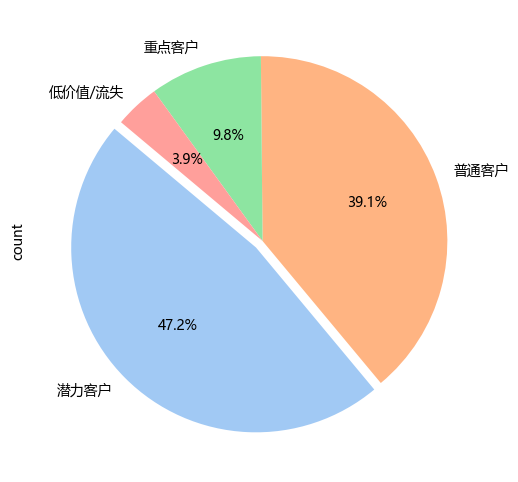

In [38]:
ax = counts.plot.pie(
    autopct='%1.1f%%',
    figsize=(6, 6),
    colors=colors,
    startangle=140,
    explode=explode
)

In [39]:
region_month = (shuju.groupby(['下单日期_yyyy_mm', '大区'], dropna=False)['销售额'].sum().reset_index())#dropna=True的意思是删除NAN值，dropna=False的意思是不删除NAN值

In [40]:
region_month.head()

,下单日期_yyyy_mm,大区,销售额
0,2015-01,Central,1533.966
1,2015-01,East,436.174
2,2015-01,South,9296.844
3,2015-01,West,2938.723
4,2015-02,Central,1233.174


In [41]:
pivot = region_month.pivot(index='下单日期_yyyy_mm', columns='大区', values='销售额')

In [42]:
pivot.head()

大区,Central,East,South,West
下单日期_yyyy_mm,,,,
2015-01,1533.966,436.174,9296.844,2938.723
2015-02,1233.174,199.776,2028.986,1057.956
2015-03,5827.602,5458.176,32911.121,11008.898
2015-04,3712.340,3054.906,12069.252,9070.357
2015-05,4044.522,7250.103,5779.240,6570.438


<Axes: xlabel='下单日期_yyyy_mm'>

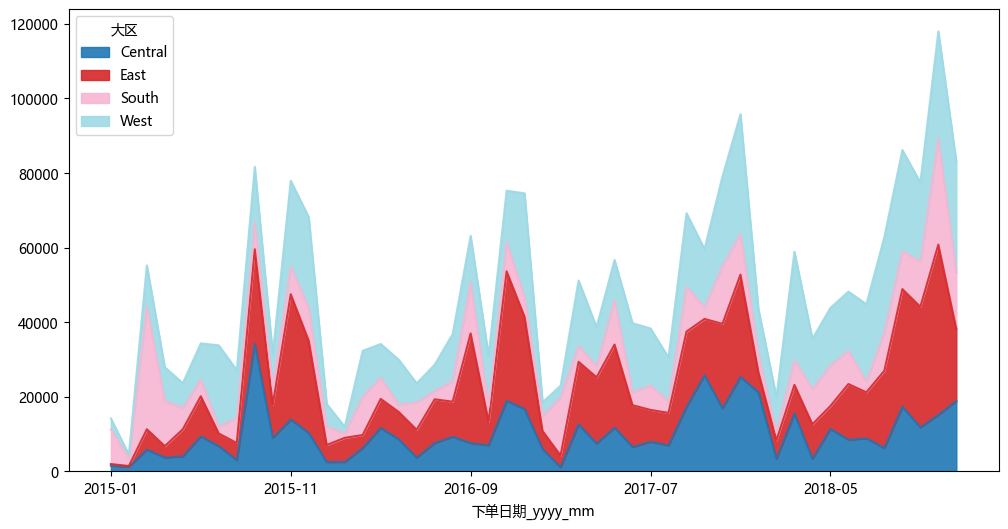

In [43]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
pivot.plot.area(ax=ax, stacked=True, colormap='tab20', alpha=0.9)